### **Setup**

In [1]:
%%bash
pip install transformers -q
pip install gensim -q

### **Library Imports**

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

from sklearn.decomposition import PCA
from transformers import AutoTokenizer, AutoModel
from gensim.parsing.preprocessing import remove_stopwords

### **Constants and Helpers**

In [3]:
TRAIN_PATH = "../input/detecting-generated-scientific-papers/fake_papers_train_part_public.csv"
TEST_PATH  = "../input/detecting-generated-scientific-papers/fake_papers_test_public.csv"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

In [4]:
def breaker(num: int=50, char: str="*") -> None:
    '''
        Line Breaker
    '''
    print("\n" + 50*"*" + "\n")


def get_model(model_id: str) -> tuple:
    '''
        Load the model from HuggingFace Hub

        1. model_id : Name of the model repository
    '''

    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModel.from_pretrained(model_id)

    return tokenizer, model


def mean_pooling(model_output, attention_mask):
    '''
        Mean Pooling - Take attention mask into account for correct averaging

        1. model_output
        2. attention_mask 
    '''

    # First element of model_output contains all token embeddings
    token_embeddings = model_output[0] 
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


def get_sentence_embeddings(model, tokenizer, query: list) -> torch.Tensor:
    '''
        Calculate sentence embeddings (Removes stop words from the Knowledge Base items or the Query)

        1. model     : Sentence Transformer Model 
        2. tokenizer : Sentence Tokenizer
        3. query     : List of Sentences (Knowledge Base) or Single Sentence (Query)
    '''

    if isinstance(query, list):
        # Convert all to lowercase and remove all the stopwords from the knowledge base
        query = [kb_item.lower() for kb_item in query]
        query = [remove_stopwords(kb_item) for kb_item in query]
    else:
        # Convert all to lowercase and remove all the stopwords from the query
        query = query.lower()
        query = remove_stopwords(query)

    # Tokenize sentences
    encoded_query = tokenizer(query, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad(): model_output = model(**encoded_query)

    # Perform pooling
    query_sentence_embeddings = mean_pooling(model_output, encoded_query['attention_mask'])

    # Normalize embeddings
    query_sentence_embeddings = F.normalize(query_sentence_embeddings, p=2, dim=1)

    # Return 
    return query_sentence_embeddings


In [5]:
train_df = pd.read_csv(TRAIN_PATH)
train_df.head(5)

,id,text,fake
0,1,Modern two-dimensional imaging is of such qual...,0
1,2,Background: The optimal sequence of systemic p...,1
2,5,This chapter opens with a discussion of the ef...,1
3,10,The time scale of the ultra-short-term can str...,1
4,23,Electronic nose or machine olfaction are syste...,1


In [6]:
first_text = [sentence for sentence in train_df.text[0].split(".") if sentence != ""]
first_text

['Modern two-dimensional imaging is of such quality that echocardiography is now capable of detecting intrapericardial formations',
 ' Three morphological types of abnormal intrapericardial echoes have been described: round masses, mattresses and linear echoes',
 ' These have been observed in effusions of various origin and seem to be lacking in aetiological specificity',
 ' In order to determine more precisely the echocardiographic signs of pericardial metastases, the authors have analyzed 7 cases of intrapericardial masses visualized in a series of 10 patients with metastatic pericardial effusion and examined in two-dimensional mode',
 ' These were echogenic and dense masses implanted on the pericardium and subject to cyclic movements linked with those of that membrane',
 ' Morphologically, they fell into two categories: - round and sessile masses (6 cases) 8 to 23 mm high and 22 to 48 mm wide at their implantation; they were found mostly opposite the cardiac apex (4 cases) and/or in

In [7]:
lengths = []

for i in range(train_df.shape[0]):
    sentence_list = [sentence for sentence in train_df.text[i].split(".") if sentence != ""]
    lengths.append(len(sentence_list))

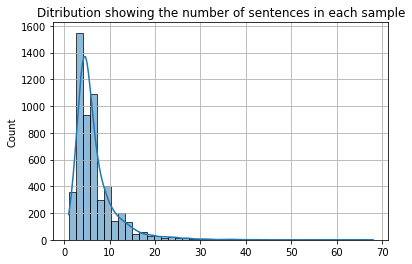

In [8]:
sns.histplot(x=lengths, bins=len(set(lengths)), kde=True)
plt.grid()
plt.title("Ditribution showing the number of sentences in each sample")
plt.show()

In [9]:
# all_sentences = []

# for i in range(train_df.shape[0]):
#     sentence_list = [sentence for sentence in train_df.text[i].split(".") if sentence != ""]
#     all_sentences.append(sentence_list)

# tokenizer, model = get_model('sentence-transformers/all-MiniLM-L6-v2')

# for sentences in all_sentences:
#     sentence_embeddings = get_sentence_embeddings(model, tokenizer, sentences)
#     break

In [10]:
tokenizer, model = get_model('sentence-transformers/all-MiniLM-L6-v2')

sentence_embeddings = torch.zeros(1, 384).to(DEVICE)

for text in train_df.text:
    sentence_embeddings = torch.cat((sentence_embeddings, get_sentence_embeddings(model, tokenizer, text)), dim=0)

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/86.7M [00:00<?, ?B/s]

In [11]:
sentence_embeddings.shape

torch.Size([5351, 384])

In [12]:
sentence_embeddings.dtype

torch.float32

In [13]:
(8 * 5351 * 384) / 1024 / 1024

15.6767578125

### **Save Embeddings**

In [14]:
torch.save(sentence_embeddings, "sentence_embeddings.pt")
np.save("sentence_embeddings.npy", sentence_embeddings.detach().cpu().numpy())

### **Class Counts**

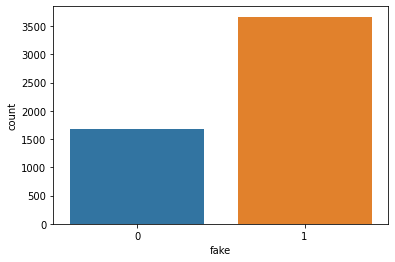

In [15]:
sns.countplot(data=train_df, x="fake")
plt.show()